# Семинар 10. Ансамбли моделей

Подключение библиотек. 
$
\newcommand{\R}{\mathbb{R}}
\newcommand{\X}{\mathbb{X}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\abs}[1]{\left| #1 \right|}
\newcommand{\E}{\mathbb{E}}
\newcommand{\D}{\mathbb{D}}
\renewcommand{\Prob}{\mathbb{P}}
\renewcommand{\le}{\leqslant}
\renewcommand{\ge}{\geqslant}
\newcommand{\eps}{\varepsilon}
\newcommand{\Normal}{\mathcal{N}}
\DeclareMathOperator{\TP}{TP}
\DeclareMathOperator{\FP}{FP}
\DeclareMathOperator{\TN}{TN}
\DeclareMathOperator{\FN}{FN}
\DeclareMathOperator{\Accuracy}{Accuracy}
\DeclareMathOperator{\Precision}{Precision}
\DeclareMathOperator{\Recall}{Recall}
\DeclareMathOperator{\Fscore}{F_1}
\DeclareMathOperator{\MSE}{MSE}
\DeclareMathOperator{\RMSE}{RMSE}
\DeclareMathOperator{\MAE}{MAE}
\DeclareMathOperator{\MAPE}{MAPE}
\DeclareMathOperator{\Rsqured}{R^2}
$

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as wg

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

cm_bright = ListedColormap(['red', 'blue'])
cm = plt.cm.get_cmap('RdBu')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 4)

In [2]:
from sklearn import set_config

set_config(display='diagram')

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def regression_metrics(true, pred, verbose=False, plot=False):
    mae = mean_absolute_error(true, pred)
    mape = np.abs((true - pred) / true).mean()
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, pred)

    if verbose:
        print('MAE: ', mae)
        print('MSE: ', mse)
        print('RMSE:', rmse)
        print('MAPE:', mape)
        print('R2:  ', r2)
        print()
        
    return (mae, mse, rmse, mape, r2)

# 1. Bootstrap

Пусть имеется выборка $X_1, \ldots, X_n$ из распределения $F(x)$.

__Задача:__ построить доверительный интервал для распределения.

In [4]:
N = 256

np.random.seed(42)
Z = np.random.normal(size=N)
loc = np.random.normal(4, 1, size=N)
scale = np.random.exponential(size=N)

X = loc + scale * Z

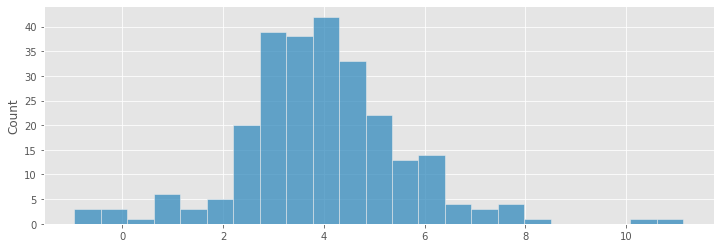

In [5]:
sns.histplot(X)
plt.show()

In [6]:
from statsmodels.stats.diagnostic import kstest_normal


ks, pvalue = kstest_normal(X, dist='norm')
print('p-value:', pvalue)

p-value: 0.006303068369654561


In [7]:
# дисперсия
np.var(X)

2.6594957703857585

Как построить доверительный интервал:
* нагенерируем новых выборок;
* оценим дисперсию на каждой;
* для полученной "выборки дисперсий" оценим квантили и построим доверительный интервал.

In [8]:
# построить гистограмму одного сэмплирования

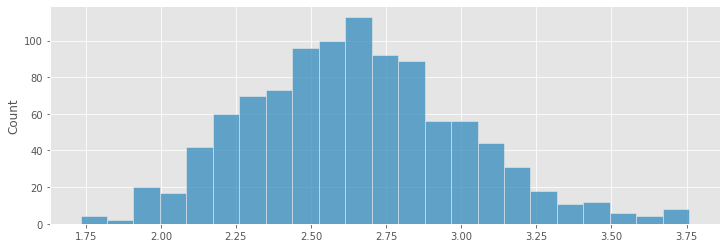

In [9]:
M = 1024
var_list = []

for _ in range(M):
    Xb = np.random.choice(X, size=N)
    var = np.var(Xb)
    
    var_list.append(var)
    
sns.histplot(var_list);

In [10]:
alpha = 0.5

q0 = np.quantile(var_list, alpha / 2)
q1 = np.quantile(var_list, 1 - alpha / 2)

print(f'alpha-confidence interval: ({q0:.5f}, {q1:.5f})')

alpha-confidence interval: (2.40489, 2.86510)


# 2. Stacking

Датасет __mpg__. По характеристикам машины необходимо спрогнозировать расход топлива.

Признаки:
* cylinders -- число цилиндров в двигателе;
* displacement -- рабочий объем, л;
* horsepower -- мощность, л.с.;
* weight -- вес, т;
* acceleration -- ускорение;
* model_year -- год выпуска модели;
* origin -- производитель;
* name -- название.

Целевая переменная:
* mpg -- миль на галлон, переведено в км/л.

In [11]:
from sklearn.preprocessing import LabelEncoder


frame = sns.load_dataset('mpg')
frame.dropna(inplace=True)

frame['displacement'] *= 16.3871 / 1000
frame['mpg'] = 100 / (frame.mpg * 1.60934 / 3.78541)
frame['weight'] *= 0.453592 / 1000
frame['origin'] = LabelEncoder().fit_transform(frame['origin'])

frame.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,13.067503,8,5.030840,130.0,1.589386,12.0,70,2,chevrolet chevelle malibu
1,15.681004,8,5.735485,165.0,1.675115,11.5,70,2,buick skylark 320
2,13.067503,8,5.211098,150.0,1.558542,11.0,70,2,plymouth satellite
3,14.700941,8,4.981678,150.0,1.557181,12.0,70,2,amc rebel sst
4,13.836180,8,4.948904,140.0,1.564439,10.5,70,2,ford torino


In [12]:
X = frame.drop(columns=['mpg', 'name']).copy()
y = frame.mpg.copy()

In [13]:
from sklearn.model_selection import train_test_split


X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Fit:', y_fit.shape)
print('Test:', y_test.shape)

Fit: (313,)
Test: (79,)


In [14]:
X.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,8,5.030840,130.0,1.589386,12.0,70,2
1,8,5.735485,165.0,1.675115,11.5,70,2
2,8,5.211098,150.0,1.558542,11.0,70,2
3,8,4.981678,150.0,1.557181,12.0,70,2
4,8,4.948904,140.0,1.564439,10.5,70,2


In [15]:
%%time
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold


num_features = ['displacement', 'horsepower', 'weight', 'acceleration', 'cylinders', 'model_year']
cat_features = ['origin']

transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), cat_features),
    ('scaler', StandardScaler(), num_features)
])

estimator = LassoCV(n_alphas=64, precompute=True, 
                    cv=KFold(10, shuffle=True, random_state=42), 
                    random_state=42, n_jobs=1)
model_lasso = Pipeline([
    ('transformer', transformer),
    ('lasso', estimator)
], verbose=0)
model_lasso.fit(X_fit, y_fit)
regression_metrics(y_test, model_lasso.predict(X_test), verbose=True);

MAE:  0.9532266527580725
MSE:  1.549048515238041
RMSE: 1.2446077756618914
MAPE: 0.0846575773941321
R2:   0.8907564410581106

CPU times: user 108 ms, sys: 10.7 ms, total: 119 ms
Wall time: 154 ms


(0.9532266527580725,
 1.549048515238041,
 1.2446077756618914,
 0.0846575773941321,
 0.8907564410581106)

In [16]:
%%time
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), cat_features),
    ('scaler', StandardScaler(), num_features)
])
estimator = SVR(C=1.0)
svr = Pipeline([
    ('transformer', transformer),
    ('svr', estimator)
], verbose=0)
model_svr = GridSearchCV(svr, {
        'svr__kernel': ('rbf', 'sigmoid', 'linear'),
        'svr__gamma': np.logspace(-3, 2, 8),
        'svr__C': np.logspace(1, 3, 4),
    }, verbose=0, n_jobs=-1,
    cv=KFold(10, shuffle=True, random_state=42)
)
model_svr.fit(X_fit, y_fit)
display(model_svr.best_estimator_)
regression_metrics(y_test, model_svr.predict(X_test), verbose=True);

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin']),
                                                 ('scaler', StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders',
                                                   'model_year'])])),
                ('svr', SVR(C=215.44346900318823, gamma=0.02682695795279726))],
         verbose=0)

MAE:  0.7945378649417277
MSE:  1.1051084836638643
RMSE: 1.0512414012318314
MAPE: 0.07296276043920573
R2:   0.9220644269145027

CPU times: user 3.87 s, sys: 249 ms, total: 4.12 s
Wall time: 26 s


(0.7945378649417277,
 1.1051084836638643,
 1.0512414012318314,
 0.07296276043920573,
 0.9220644269145027)

In [17]:
%%time
from sklearn.tree import DecisionTreeRegressor


tree = DecisionTreeRegressor(random_state=42)
model_tree = GridSearchCV(tree, dict(
        max_depth=(2, 5, 10, 20, 30),
        min_samples_leaf=(1, 5, 10, 15, 20),
    ), verbose=0, n_jobs=1,
    cv=KFold(10, shuffle=True, random_state=42)
)
model_tree.fit(X_fit, y_fit)
display(model_tree.best_estimator_)

regression_metrics(y_test, model_tree.predict(X_test), verbose=True);

DecisionTreeRegressor(max_depth=5, random_state=42)

MAE:  1.1502366074816843
MSE:  2.27634965314718
RMSE: 1.508757652224896
MAPE: 0.10076744158164772
R2:   0.8394649779786145

CPU times: user 1.73 s, sys: 30.2 ms, total: 1.76 s
Wall time: 2.69 s


(1.1502366074816843,
 2.27634965314718,
 1.508757652224896,
 0.10076744158164772,
 0.8394649779786145)

In [18]:
%%time
from sklearn.ensemble import RandomForestRegressor


forest = RandomForestRegressor(
    criterion='mse',
    max_depth=3,
    random_state=42,
    n_jobs=1
)
model_forest = GridSearchCV(forest, dict(
        n_estimators=(50, 100, 150),
        max_depth=(5, 10, 20, 30),
        min_samples_leaf=(1, 5, 10, 15),
    ), verbose=0, n_jobs=-1,
    cv=KFold(10, shuffle=True, random_state=42)
)
model_forest.fit(X_fit, y_fit)
display(model_forest.best_estimator_)

regression_metrics(y_test, model_forest.predict(X_test), verbose=True);

RandomForestRegressor(max_depth=20, n_estimators=50, n_jobs=1, random_state=42)

MAE:  0.8684085172896095
MSE:  1.3686828520134957
RMSE: 1.1699071980347397
MAPE: 0.07552157350051855
R2:   0.9034763699484822

CPU times: user 3.57 s, sys: 145 ms, total: 3.72 s
Wall time: 19.6 s


(0.8684085172896095,
 1.3686828520134957,
 1.1699071980347397,
 0.07552157350051855,
 0.9034763699484822)

Пробуем стэкинг:

In [19]:
%%time
from sklearn.ensemble import StackingRegressor


stacking = StackingRegressor([
        ('lasso', model_lasso), 
        ('tree', model_tree.best_estimator_), 
        ('svr', model_svr.best_estimator_),
        ('forest', model_forest.best_estimator_),
    ], verbose=1, n_jobs=1,
    cv=KFold(5, shuffle=True, random_state=42)
)
stacking.fit(X_fit, y_fit)

regression_metrics(y_test, stacking.predict(X_test), verbose=True);

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MAE:  0.7869406192723031
MSE:  1.0778836687421665
RMSE: 1.0382117648833336
MAPE: 0.07000730658411883
R2:   0.9239844027217959

CPU times: user 1.81 s, sys: 26.6 ms, total: 1.83 s
Wall time: 2.74 s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


(0.7869406192723031,
 1.0778836687421665,
 1.0382117648833336,
 0.07000730658411883,
 0.9239844027217959)

# 3. Bagging

In [20]:
%%time
from sklearn.ensemble import BaggingRegressor


bagging = BaggingRegressor(
    tree, 
    n_estimators=200, 
    bootstrap=True, 
    bootstrap_features=True, 
    n_jobs=-1, 
    random_state=42
)
bagging.fit(X_fit, y_fit)
regression_metrics(y_test, bagging.predict(X_test), verbose=True);

MAE:  0.8366039717297616
MSE:  1.3193207825042423
RMSE: 1.148616899799164
MAPE: 0.07422744654452323
R2:   0.9069575315111329

CPU times: user 210 ms, sys: 22.6 ms, total: 233 ms
Wall time: 465 ms


(0.8366039717297616,
 1.3193207825042423,
 1.148616899799164,
 0.07422744654452323,
 0.9069575315111329)

# 4. Boosting

In [21]:
%%time
from sklearn.ensemble import AdaBoostRegressor


adaboost = AdaBoostRegressor(
    learning_rate=1.0, 
    random_state=42
)
model_adaboost = GridSearchCV(adaboost, dict(
    base_estimator=(
        DecisionTreeRegressor(max_depth=10, random_state=42),
        DecisionTreeRegressor(max_depth=5, random_state=42),
        DecisionTreeRegressor(max_depth=3, random_state=42),
    ),
    n_estimators=(30, 40, 50, 60, 70),
), n_jobs=-1, cv=KFold(10, shuffle=True, random_state=42))
model_adaboost.fit(X_fit, y_fit)
display(model_adaboost.best_estimator_)

regression_metrics(y_test, model_adaboost.predict(X_test), verbose=True);

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                       random_state=42),
                  n_estimators=70, random_state=42)

MAE:  0.8033460460018739
MSE:  1.2220677745035005
RMSE: 1.105471742969263
MAPE: 0.07088919493657346
R2:   0.9138161060536949

CPU times: user 1.17 s, sys: 43.5 ms, total: 1.21 s
Wall time: 3.54 s


(0.8033460460018739,
 1.2220677745035005,
 1.105471742969263,
 0.07088919493657346,
 0.9138161060536949)

In [22]:
%%time
from xgboost import XGBRegressor


xgb = XGBRegressor(
    n_jobs=1,
    random_state=42
)

model_xgb = GridSearchCV(xgb, {
        'n_estimators':(100, 150, 200),
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'booster': ['gbtree', 'gblinear', 'dart'],
    }, n_jobs=-1, verbose=10,
    cv=KFold(5, shuffle=True, random_state=42)
)
model_xgb.fit(X_fit, y_fit)
display(model_xgb.best_estimator_)

regression_metrics(y_test, model_xgb.predict(X_test), verbose=True);

Fitting 5 folds for each of 3645 candidates, totalling 18225 fits


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

MAE:  0.9949393673205574
MSE:  1.7825767709734441
RMSE: 1.3351317429278071
MAPE: 0.08859492508273957
R2:   0.8742873262956806

CPU times: user 1min 32s, sys: 3.18 s, total: 1min 35s
Wall time: 3min 58s


(0.9949393673205574,
 1.7825767709734441,
 1.3351317429278071,
 0.08859492508273957,
 0.8742873262956806)